In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from torchvision import transforms, models
import torch.nn.functional as F

import numpy as np
import ast
import matplotlib.pyplot as plt

import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
from timeit import default_timer as timer

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [3]:
# Image transformations (from tutorial)
image_transforms = {
    # Train augments images
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # No augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # No augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
class MovieAttributeDataset(Dataset):
    """Custom PyTorch Dataset for movie data 
    """
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        budget = self.img_labels.iloc[idx, 1]
        genres = torch.Tensor(ast.literal_eval(self.img_labels.iloc[idx, 2]))
        if self.transform:
            image = self.transform(image)
        return image, budget, genres

In [5]:
train_dataset = MovieAttributeDataset(annotations_file="train_set_15_shots.csv", img_dir="", transform=image_transforms["train"])
# train_dataset = MovieAttributeDataset(annotations_file="train_set_all_shots.csv", img_dir="", transform=image_transforms["train"])
val_dataset = MovieAttributeDataset(annotations_file="val_set.csv", img_dir="", transform=image_transforms["val"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [6]:
# Visualize data in each training batch
for images, budgets, genres in train_dataloader:
    print(images.shape) # (batch_size, color_channels, height, width)
    print(budgets.shape)
    print(genres.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 22])


In [6]:
# Modified from tutorial
def train(model,
          criterion1,
          criterion2,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion1 (PyTorch loss): objective to minimize budget prediction error
        criterion2 (PyTorch loss): objective to minimize genres prediction error
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_budget_acc = 0
        train_genre_acc = 0
        valid_budget_acc = 0
        valid_genre_acc = 0

        total_genres = 0

        # Set to training
        model.train()
        start = timer()

        ## training step
        for ii, (images, budgets, genres) in enumerate(train_loader):

            images = images.to(device)
            budgets = budgets.to(device)
            genres = genres.to(device)

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are non-log logits
            budget_pred, genre_pred = model(images)

            # Loss and backpropagation of gradients
            loss1 = criterion1(budget_pred, budgets)
            loss2 = criterion2(genre_pred, genres)
            loss = loss1 + loss2
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * images.size(0)

            # Multiply average accuracy times the number of examples in batch
            # 1. Budget accuracy by finding max log probability
            _, pred1 = torch.max(budget_pred, dim=1)
            correct_tensor = pred1.eq(budgets.data.view_as(pred1))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_budget_acc += accuracy.item() * images.size(0)

            # 2. Genre accuracy (3 metrics)
            _, idx = genre_pred.topk(3, dim=1)
            pred2 = torch.zeros_like(genre_pred)
            pred2[torch.arange(genres.size(0)).unsqueeze(1), idx] = 1

            # (a) Compare top 3 most likely genres to ground truth
            diff = pred2 - genres
            miss = torch.nonzero(diff < 0).size(0)
            actual = torch.nonzero(genres).size(0)
            total_genres += actual
            train_genre_acc += actual - miss

            # (b) Compare the most likely genre to ground truth
            # max_i = torch.argmax(pred2, dim=1)
            # c = genres[torch.arange(genres.size(0)), max_i] == 1
            # train_genre_acc += torch.count_nonzero(c)

            # (c) Compare genres it is not likely to be as well
            # correct2 = pred2.eq(genres.data.view_as(pred2))
            # genre_accuracy = torch.mean(correct2.type(torch.FloatTensor))
            # train_genre_acc += genre_accuracy.item() * genres.size(0)
            
            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for images, budgets, genres in valid_loader:
                    # Tensors to gpu
                    images = images.to(device)
                    budgets = budgets.to(device)
                    genres = genres.to(device)

                    # Forward pass
                    budget_pred, genre_pred = model(images)

                    # Validation loss
                    loss1 = criterion1(budget_pred, budgets)
                    loss2 = criterion2(genre_pred, genres)
                    loss = loss1 + loss2
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * images.size(0)

                    # Calculate validation accuracy
                    # 1. Budget accuracy
                    _, pred = torch.max(budget_pred, dim=1)
                    correct_tensor = pred.eq(budgets.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    valid_budget_acc += accuracy.item() * images.size(0)

                    # 2. Genre accuracy
                    _, idx = genre_pred.topk(3, dim=1)
                    pred2 = torch.zeros_like(genre_pred)
                    pred2[torch.arange(genres.size(0)).unsqueeze(1), idx] = 1

                    # (a) Compare top 3 most likely genres to ground truth
                    diff = pred2 - genres
                    miss = torch.nonzero(diff < 0).size(0)
                    actual = torch.nonzero(genres).size(0)
                    valid_genre_acc += actual - miss

                    # (b) Compare the most likely genre to ground truth
                    # max_i = torch.argmax(pred2, dim=1)
                    # c = genres[torch.arange(genres.size(0)), max_i] == 1
                    # valid_genre_acc += torch.count_nonzero(c)

                    # (c) Compare genres it is not likely to be as well
                    # correct_tensor2 = pred2.eq(genres.data.view_as(pred2))
                    # accuracy2 = torch.mean(correct_tensor2.type(torch.FloatTensor))
                    # valid_genre_acc += accuracy2.item() * genres.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_budget_acc = train_budget_acc / len(train_loader.dataset)
                train_genre_acc = train_genre_acc / total_genres
                valid_budget_acc = valid_budget_acc / len(valid_loader.dataset)
                valid_genre_acc = valid_genre_acc / total_genres

                history.append([train_loss, valid_loss, train_budget_acc, valid_budget_acc, train_genre_acc, valid_genre_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tBudget Training Accuracy: {100 * train_budget_acc:.2f}%\t Budget Validation Accuracy: {100 * valid_budget_acc:.2f}%'
                    )
                    print(
                        f'\t\tGenre Training Accuracy: {100 * train_genre_acc:.2f}%\t Genre Validation Accuracy: {100 * valid_genre_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f}'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_budget_acc', 
                                'valid_budget_acc', 'train_genre_acc', 'valid_genre_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f}'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_budget_acc', 'valid_budget_acc', 'train_genre_acc', 'valid_genre_acc'])
    return model, history

In [8]:
budget_ground = pd.read_csv("train_set_15_shots.csv")
# budget_ground = pd.read_csv("train_set_all_shots.csv")
budget_ground = budget_ground['budget'].values
total = len(budget_ground)
weight_scale = []
for i in range(np.max(budget_ground) + 1):
    weight_scale.append(1/(np.sum(budget_ground == i)/total))
weight_scale = torch.tensor(weight_scale).float()
weight_scale = weight_scale.to(device)

In [9]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=weight_scale)
criterion2 = nn.BCEWithLogitsLoss(reduction='mean') # binary cross entropy loss + softmax

## Custom model training

In [341]:
class CustomMovieModel(nn.Module):
    def __init__(self):
        super(CustomMovieModel, self).__init__()
        # m x m x 3 image
        # 224x224x3 => 222x222x32, kernel: k -> m - k + 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=11)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.d = nn.Sequential(
            nn.Linear(7 * 7 * 128, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.4)
        )

        self.o1 = nn.Linear(256, 5)
        self.o2 = nn.Linear(256, 22)

    def forward(self, x):
        # 64x3x224x224 => 64x128x7x7
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.avgpool(x)
        # flatten => 64 x (128*7*7)
        x = x.flatten(start_dim = 1)

        # 64 x (128*7*7) => 64x256
        x = self.d(x)

        # logits (the raw, unnormalized predictions) => 64x5
        out = self.o1(x)

        # logits (the raw, unnormalized predictions) => 64x22
        out2 = self.o2(x)
        return out, out2

In [344]:
model = CustomMovieModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
_, history = train(model, criterion, criterion2, optimizer, train_dataloader, val_dataloader, "custom.pt", 3, 10, 1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 77.97 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 7.6459 	Validation Loss: 1.9307
		Budget Training Accuracy: 18.18%	 Budget Validation Accuracy: 11.11%
		Genre Training Accuracy: 38.36%	 Genre Validation Accuracy: 3.60%
Epoch: 1	100.00% complete. 71.14 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.9577 	Validation Loss: 1.9122
		Budget Training Accuracy: 25.07%	 Budget Validation Accuracy: 11.11%
		Genre Training Accuracy: 42.36%	 Genre Validation Accuracy: 3.60%
Epoch: 2	100.00% complete. 71.95 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.9470 	Validation Loss: 1.9295
		Budget Training Accuracy: 22.85%	 Budget Validation Accuracy: 0.00%
		Genre Training Accuracy: 42.18%	 Genre Validation Accuracy: 3.60%
Epoch: 3	100.00% complete. 71.06 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.9456 	Validation Loss: 1.8720
		Budget Training Accuracy: 25.01%	 Budget Validation Accuracy: 55.56%
		Genre Training

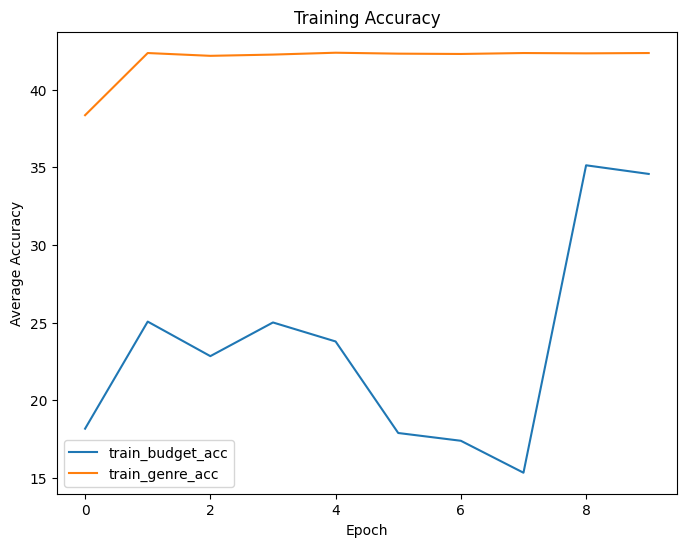

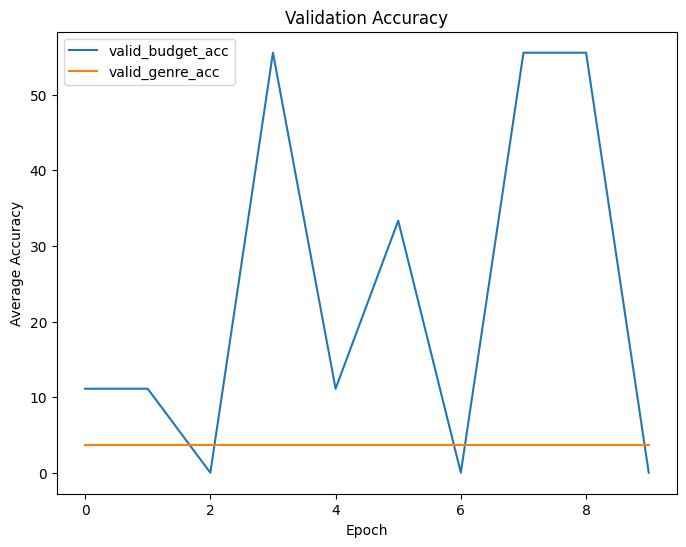

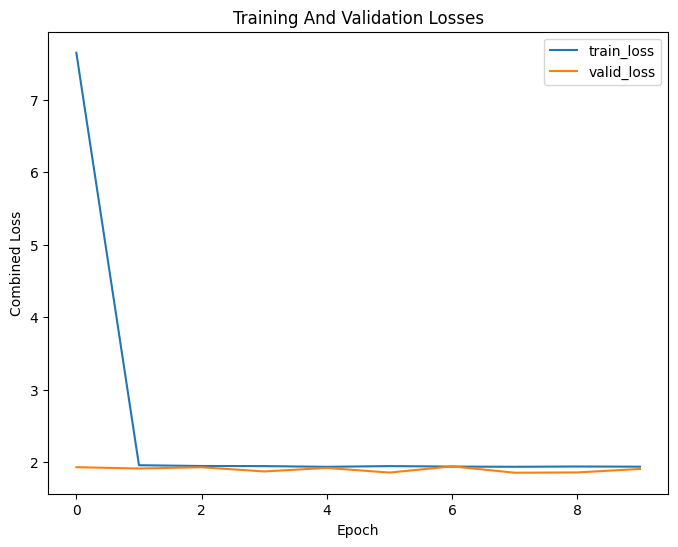

In [346]:
# Visualization
plt.figure(figsize=(8, 6))
for c in ['train_budget_acc', 'train_genre_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training Accuracy')
plt.show()

plt.figure(figsize=(8, 6))
for c in ['valid_budget_acc', 'valid_genre_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Validation Accuracy')
plt.show()

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.title('Training And Validation Losses')
plt.show()

## Resnet18 pretrained model training

In [10]:
class ResnetPretrainedModel(nn.Module):
    def __init__(self, resnet):
        super(ResnetPretrainedModel, self).__init__()
        self.resnet = resnet
        self.resnet.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Dropout()
        )

        self.output1 = nn.Linear(256, 5)
        self.output2 = nn.Linear(256, 22)

    def forward(self, x):
        x = self.resnet(x)
        output1 = self.output1(x)
        output2 = self.output2(x)
        return output1, output2

In [348]:
resnet18 = models.resnet18(weights='ResNet18_Weights.DEFAULT')

for param in resnet18.parameters():
    param.requires_grad = False

model3 = ResnetPretrainedModel(resnet18)
model3 = model3.to(device)

# Show which parameter weights will be changed during training
# for name,param in model3.named_parameters():
#     if param.requires_grad == True:
#         print("\t",name)

optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
_, history3 = train(model3, criterion, criterion2, optimizer, train_dataloader, val_dataloader, "resnet18.pt", 3, 10, 2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 20.05 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.0053 	Validation Loss: 1.9316
		Budget Training Accuracy: 14.29%	 Budget Validation Accuracy: 0.00%
		Genre Training Accuracy: 41.74%	 Genre Validation Accuracy: 3.60%
Epoch: 3	100.00% complete. 21.04 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.9443 	Validation Loss: 1.9251
		Budget Training Accuracy: 16.95%	 Budget Validation Accuracy: 0.00%
		Genre Training Accuracy: 42.44%	 Genre Validation Accuracy: 3.60%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 1.78
88.21 total seconds elapsed. 22.05 seconds per epoch.


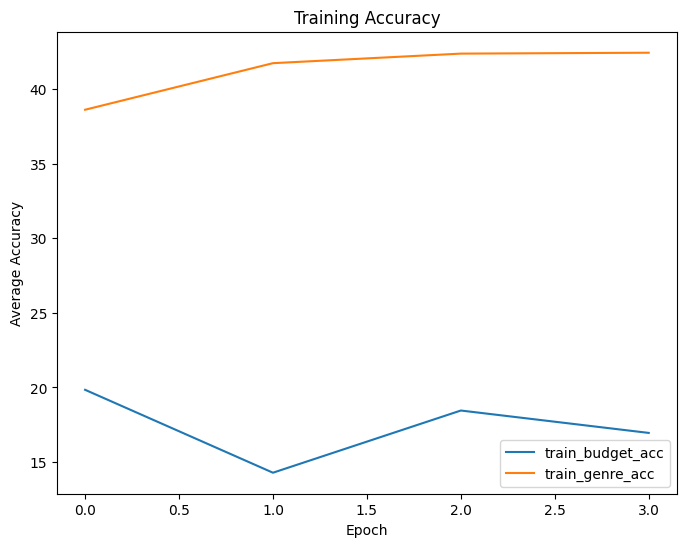

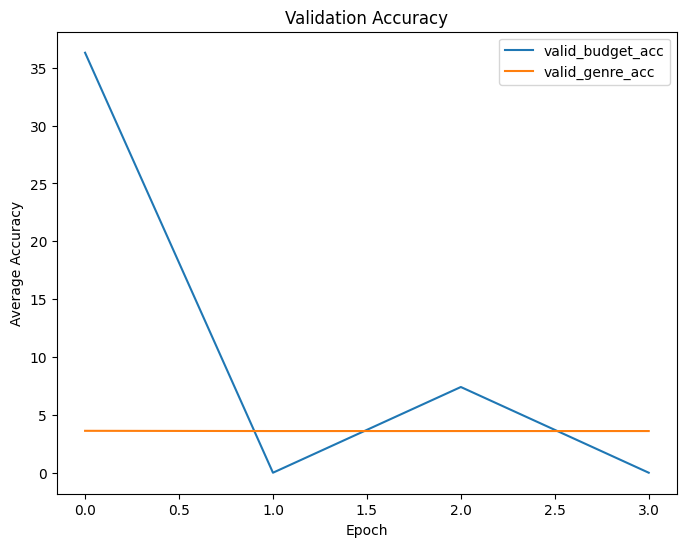

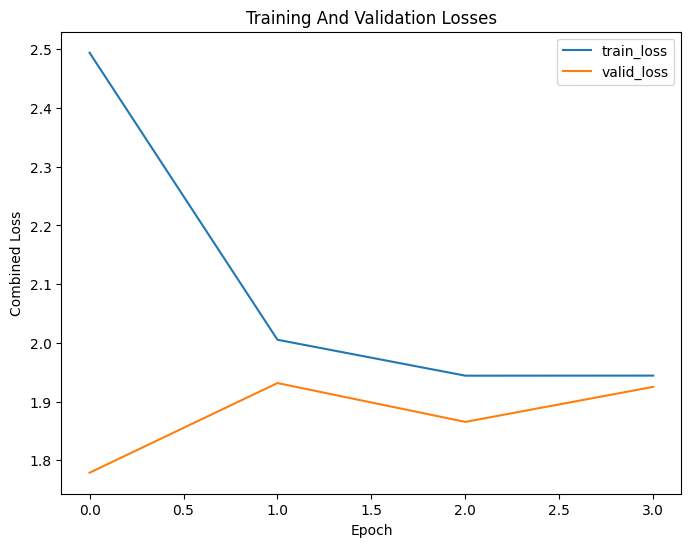

In [359]:
# Visualization
plt.figure(figsize=(8, 6))
for c in ['train_budget_acc', 'train_genre_acc']:
    plt.plot(
        100 * history3[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training Accuracy')
plt.show()

plt.figure(figsize=(8, 6))
for c in ['valid_budget_acc', 'valid_genre_acc']:
    plt.plot(
        100 * history3[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Validation Accuracy')
plt.show()

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history3[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.title('Training And Validation Losses')
plt.show()

## Vgg16 pretrained model training

In [360]:
class VggPretrainedModel(nn.Module):
    def __init__(self, vgg_features):
        super(VggPretrainedModel, self).__init__()
        self.features = vgg_features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Dropout()
        )
        
        self.output1 = nn.Linear(256, 5)
        self.output2 = nn.Linear(256, 22)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output1 = self.output1(x)
        output2 = self.output2(x)
        return output1, output2

In [361]:
vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')

# Step 2: Freeze parameters of pre-trained layers
for param in vgg16.parameters():
    param.requires_grad = False

# Extract features from VGG16
features = vgg16.features

model2 = VggPretrainedModel(features)
model2 = model2.to(device)

# Show which parameter weights will be changed during training
# for name,param in model2.named_parameters():
#     if param.requires_grad == True:
#         print("\t",name)

optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
_, history2 = train(model2, criterion, criterion2, optimizer, train_dataloader, val_dataloader, "vgg16.pt", 3, 10, 2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 35.60 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.2459 	Validation Loss: 1.8474
		Budget Training Accuracy: 16.90%	 Budget Validation Accuracy: 49.63%
		Genre Training Accuracy: 41.62%	 Genre Validation Accuracy: 3.68%
Epoch: 3	100.00% complete. 25.00 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 2.0473 	Validation Loss: 1.8833
		Budget Training Accuracy: 23.12%	 Budget Validation Accuracy: 33.33%
		Genre Training Accuracy: 42.48%	 Genre Validation Accuracy: 3.60%
Epoch: 4	100.00% complete. 25.47 seconds elapsed in epoch.
Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 1.85
161.94 total seconds elapsed. 32.39 seconds per epoch.


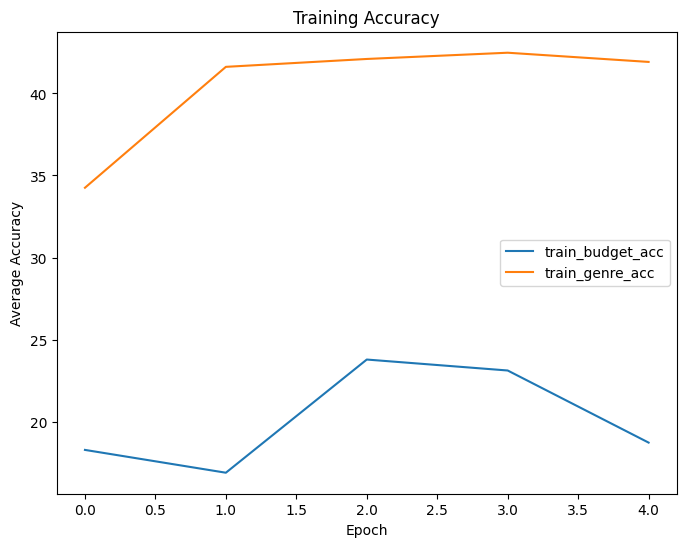

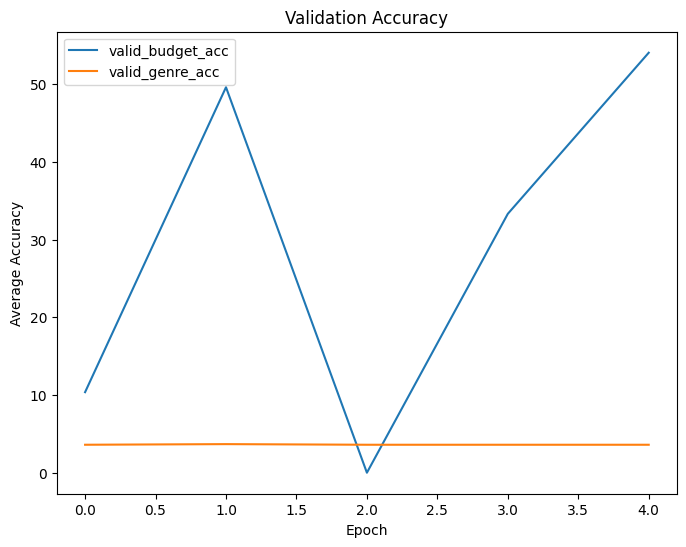

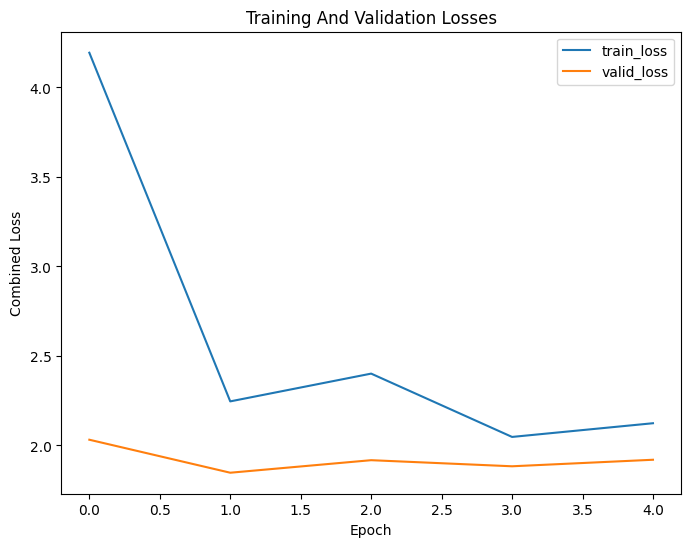

In [372]:
# Visualization
plt.figure(figsize=(8, 6))
for c in ['train_budget_acc', 'train_genre_acc']:
    plt.plot(
        100 * history2[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training Accuracy')
plt.show()

plt.figure(figsize=(8, 6))
for c in ['valid_budget_acc', 'valid_genre_acc']:
    plt.plot(
        100 * history2[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Validation Accuracy')
plt.show()

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history2[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.title('Training And Validation Losses')
plt.show()

## Testing code

In [13]:
def test(model, test_dataloader):
    budget_acc = 0
    genre_acc = 0
    total_genres = 0
    for (images, budgets, genres) in test_dataloader:
        out1, out2 = model(images)
        
        # 1. Budget accuracy by finding max index of logits
        budget_pred = torch.argmax(out1, dim=1)
        correct = budget_pred.eq(budgets.data.view_as(budget_pred))

        # Need to convert correct tensor from int to float to average 
        # Then multiply average accuracy times the number of examples in batch
        budget_accuracy = torch.mean(correct.type(torch.FloatTensor))
        budget_acc += budget_accuracy.item() * images.size(0)

        # 2. Genre accuracy
        _, idx = out2.topk(3, dim=1)
        genre_pred = torch.zeros_like(out2)
        genre_pred[torch.arange(genres.size(0)).unsqueeze(1), idx] = 1

        # (a) Compare top 3 most likely genres to ground truth
        diff = genre_pred - genres
        miss = torch.nonzero(diff < 0).size(0)
        actual = torch.nonzero(genres).size(0)
        total_genres += actual
        genre_acc += actual - miss

        # (b) Compare the most likely genre to ground truth
        # max_i = torch.argmax(genre_pred, dim=1)
        # c = genres[torch.arange(genres.size(0)), max_i] == 1
        # genre_acc += torch.count_nonzero(c)

        # (c) Compare genres it is not likely to be as well
        # correct2 = genre_pred.eq(genres.data.view_as(genre_pred))
        # genre_accuracy = torch.mean(correct2.type(torch.FloatTensor))
        # genre_acc += genre_accuracy.item() * genres.size(0)
    
    budget_acc = budget_acc / len(test_dataloader.dataset)
    genre_acc = genre_acc / total_genres
    print(
        f'Budget Accuracy: {100 * budget_acc:.2f}%\t Genre Accuracy: {100 * genre_acc:.2f}%'
    )

In [14]:
test_dataset = MovieAttributeDataset(annotations_file="test_set_15_shots.csv", img_dir="", transform=image_transforms["test"])
# test_dataset = MovieAttributeDataset(annotations_file="test_set_all_shots.csv", img_dir="", transform=image_transforms["test"])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [371]:
final = CustomMovieModel()
final.load_state_dict(torch.load('custom.pt'))
test(final, test_dataloader)

Budget Accuracy: 36.30%	 Genre Accuracy: 32.00%


In [358]:
final3 = ResnetPretrainedModel(resnet18)
final3 = final3.to('cpu')
final3.load_state_dict(torch.load('resnet18.pt'))
test(final3, test_dataloader)

Budget Accuracy: 22.96%	 Genre Accuracy: 32.00%


In [362]:
final2 = VggPretrainedModel(features)
final2 = final2.to('cpu')
final2.load_state_dict(torch.load('vgg16.pt'))
test(final2, test_dataloader)

Budget Accuracy: 22.96%	 Genre Accuracy: 32.27%
